In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
print(os.path.exists('/content/drive/MyDrive/Colab Notebooks/ChatGPT-promises-and-pitfalls-main/humanCode'))


True


In [3]:
!pip install radon


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 3.4 MB/s eta 0:00:00


In [4]:
!python "/content/drive/MyDrive/Colab Notebooks/ChatGPT-promises-and-pitfalls-main/metrics.py"

In [5]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ChatGPT-promises-and-pitfalls-main/data/humanCodeMetrics.csv")
df.head()


,File,Category,Subcategory,More Accurate/Less Accurate,Cyclomatic Complexity,SLoC,Halstead Distinct Operators,Halstead Distinct Operands,Comments
0,takes-a-file-and-a-line-number-and-prints-the-...,data-analysis,data-storage,more,2,6,1,2,1
1,compresses-and-decompresses-a-text-file.py,data-analysis,data-storage,more,2,16,1,2,0
2,takes-a-json-file-and-reads-it-into-the-progra...,data-analysis,data-storage,more,2,8,0,0,1
3,converts-a-csv-file-to-a-json-file.py,data-analysis,data-storage,more,3,11,1,2,1
4,generates-some-amount-of-random-numbers-and-st...,data-analysis,data-storage,more,2,10,0,0,1


In [6]:
#Prepare the dataset
import pandas as pd

# Load CSV files
human_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ChatGPT-promises-and-pitfalls-main/data/humanCodeMetrics.csv')
chatgpt_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ChatGPT-promises-and-pitfalls-main/data/3.5metrics.csv')

# Add labels
human_df['Label'] = 0       # Human-generated code
chatgpt_df['Label'] = 1     # ChatGPT-generated code



In [7]:
# Combine datasets
df = pd.concat([human_df, chatgpt_df], ignore_index=True)

In [8]:
# Inspect combined data
df.head()


,File,Category,Subcategory,More Accurate/Less Accurate,Cyclomatic Complexity,SLoC,Halstead Distinct Operators,Halstead Distinct Operands,Comments,Label,Notes
0,takes-a-file-and-a-line-number-and-prints-the-...,data-analysis,data-storage,more,2,6,1,2,1,0,NaN
1,compresses-and-decompresses-a-text-file.py,data-analysis,data-storage,more,2,16,1,2,0,0,NaN
2,takes-a-json-file-and-reads-it-into-the-progra...,data-analysis,data-storage,more,2,8,0,0,1,0,NaN
3,converts-a-csv-file-to-a-json-file.py,data-analysis,data-storage,more,3,11,1,2,1,0,NaN
4,generates-some-amount-of-random-numbers-and-st...,data-analysis,data-storage,more,2,10,0,0,1,0,NaN


In [9]:
#Define Features and Labels
X = df.drop(['File', 'Category', 'Subcategory', 'More Accurate/Less Accurate', 'Label', 'Notes'], axis=1)
y = df['Label']

In [10]:
print(X.head())

   Cyclomatic Complexity  SLoC  Halstead Distinct Operators  \
0                      2     6                            1   
1                      2    16                            1   
2                      2     8                            0   
3                      3    11                            1   
4                      2    10                            0   

   Halstead Distinct Operands  Comments  
0                           2         1  
1                           2         0  
2                           0         1  
3                           2         1  
4                           0         1  


In [11]:
print(y.head())

0    0
1    0
2    0
3    0
4    0
Name: Label, dtype: int64


In [17]:
# Train-Test Split & Normalize Data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
print(X_train.shape)

(209, 5)


In [19]:
print(X_test.shape)

(53, 5)


In [20]:
####################################
# 2. Autoencoder Pretraining
####################################

import tensorflow as tf
from tensorflow.keras import layers, models

# -- Autoencoder Architecture --
# We'll choose a symmetrical architecture for encoding and decoding

input_dim = X_train_scaled.shape[1]  # number of features
encoding_dim = 32                    # latent dimensionality (tunable)

# Encoder
input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(64, activation='relu')(input_layer)
encoded = layers.Dense(encoding_dim, activation='relu')(encoded)

# Decoder
decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(input_dim, activation='linear')(decoded)

# Full autoencoder model
autoencoder = models.Model(inputs=input_layer, outputs=decoded)

autoencoder.compile(
    optimizer='adam',
    loss='mse'  # reconstruct input, so MSE is a typical choice
)

# Train the autoencoder (unsupervised)
history_ae = autoencoder.fit(
    X_train_scaled, X_train_scaled,
    epochs=30,
    batch_size=8,
    validation_split=0.2,
    verbose=1
)

Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 1.0800 - val_loss: 0.6867
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.7950 - val_loss: 0.4295
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3752 - val_loss: 0.2189
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2093 - val_loss: 0.1628
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1445 - val_loss: 0.0956
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0761 - val_loss: 0.0475
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0393 - val_loss: 0.0329
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0342 - val_loss: 0.0297
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0199 - val_loss: 0.0216
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0141 - val_loss: 0.0199
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0127 - val_loss: 0.0173
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0100 - val_l

In [21]:
####################################
# 3. Build Classifier Using the Encoder
####################################

# We'll extract the "encoder" part of the autoencoder
encoder = models.Model(inputs=input_layer, outputs=encoded)

# Freeze the encoder at first, so we don’t destroy its weights right away
for layer in encoder.layers:
    layer.trainable = False

# Now define a new model that uses encoder output -> classification layers
classifier_input = layers.Input(shape=(input_dim,))
encoded_features = encoder(classifier_input)

# Classification head
x = layers.Dropout(0.3)(encoded_features)
x = layers.Dense(16, activation='relu')(x)
x = layers.Dropout(0.2)(x)
output = layers.Dense(1, activation='sigmoid')(x)

classifier = models.Model(inputs=classifier_input, outputs=output)

classifier.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [22]:
# Train the classifier (with encoder frozen)
history_classifier_1 = classifier.fit(
    X_train_scaled, y_train,
    epochs=15,
    batch_size=8,
    validation_data=(X_test_scaled, y_test),
    verbose=1
)

# Evaluate after phase 1 of training
loss, accuracy = classifier.evaluate(X_test_scaled, y_test, verbose=0)
print(f"[Phase 1 - Frozen Encoder] Test Accuracy: {accuracy:.2%}")

Epoch 1/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.4400 - loss: 0.8710 - val_accuracy: 0.5094 - val_loss: 0.7827
Epoch 2/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5724 - loss: 0.7444 - val_accuracy: 0.4528 - val_loss: 0.7477
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4795 - loss: 0.7493 - val_accuracy: 0.4340 - val_loss: 0.7275
Epoch 4/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4512 - loss: 0.7492 - val_accuracy: 0.4906 - val_loss: 0.7145
Epoch 5/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4710 - loss: 0.7194 - val_accuracy: 0.4906 - val_loss: 0.7016
Epoch 6/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5048 - loss: 0.7057 - val_accuracy: 0.5283 - val_loss: 0.6965
Epoch 7/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5368 - loss: 0.6955 - val_accuracy: 0.5094 - val_loss: 0.6900
Epoch 8/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4998 - loss: 0.7295 - val_accuracy: 0.5283 - val_loss

In [28]:
####################################
# 4. Fine-Tuning the Encoder
####################################

# Now we unfreeze the encoder so it can adapt more closely to the classification task
for layer in encoder.layers:
    layer.trainable = True

# Re-compile with a lower learning rate to avoid destroying the learned weights
classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_classifier_2 = classifier.fit(
    X_train_scaled, y_train,
    epochs=15,
    batch_size=8,
    validation_data=(X_test_scaled, y_test),
    verbose=1
)

Epoch 1/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.6983 - loss: 0.6359 - val_accuracy: 0.6038 - val_loss: 0.6509
Epoch 2/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6254 - loss: 0.6476 - val_accuracy: 0.6226 - val_loss: 0.6501
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6550 - loss: 0.6326 - val_accuracy: 0.6415 - val_loss: 0.6483
Epoch 4/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6485 - loss: 0.6454 - val_accuracy: 0.6604 - val_loss: 0.6477
Epoch 5/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6969 - loss: 0.6308 - val_accuracy: 0.6604 - val_loss: 0.6471
Epoch 6/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6707 - loss: 0.6347 - val_accuracy: 0.6604 - val_loss: 0.6463
Epoch 7/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6148 - loss: 0.6448 - val_accuracy: 0.6792 - val_loss: 0.6459
Epoch 8/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7331 - loss: 0.6171 - val_accuracy: 0.6604 - val_loss

In [29]:
# Final evaluation
loss, accuracy = classifier.evaluate(X_test_scaled, y_test, verbose=0)
print(f"[Phase 2 - Fine-Tuned Encoder] Final Test Accuracy: {accuracy:.2%}")

[Phase 2 - Fine-Tuned Encoder] Final Test Accuracy: 66.04%


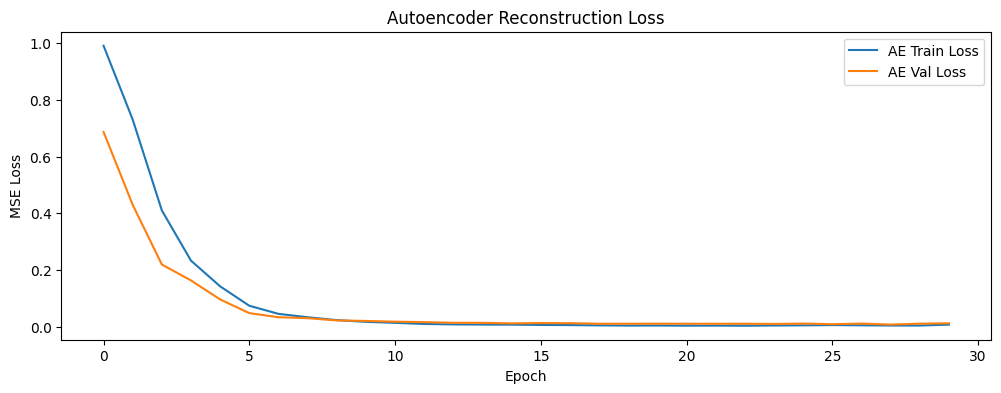

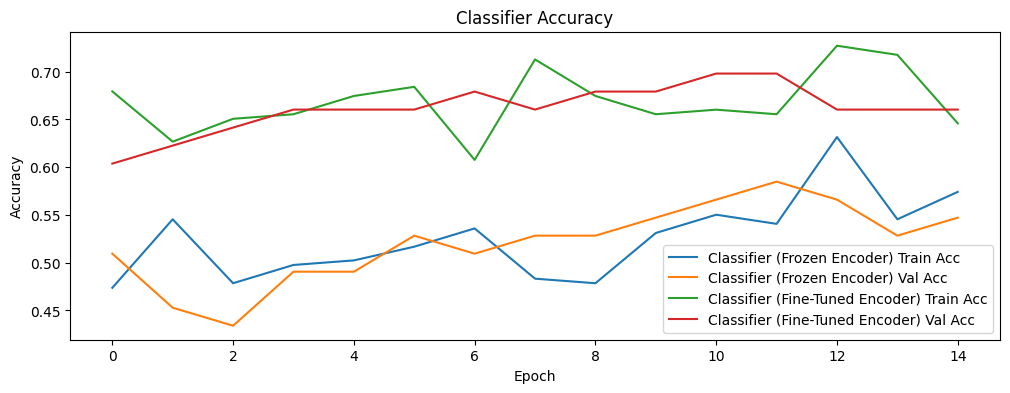

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step
              precision    recall  f1-score   support

       Human       0.67      0.62      0.64        26
     ChatGPT       0.66      0.70      0.68        27

    accuracy                           0.66        53
   macro avg       0.66      0.66      0.66        53
weighted avg       0.66      0.66      0.66        53

TensorFlow version: 2.18.0


In [30]:
####################################
# 5. Visualization and Reports
####################################

import matplotlib.pyplot as plt

# Plot autoencoder loss
plt.figure(figsize=(12, 4))
plt.plot(history_ae.history['loss'], label='AE Train Loss')
plt.plot(history_ae.history['val_loss'], label='AE Val Loss')
plt.title('Autoencoder Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

# Plot classifier training accuracy
plt.figure(figsize=(12, 4))
plt.plot(history_classifier_1.history['accuracy'], label='Classifier (Frozen Encoder) Train Acc')
plt.plot(history_classifier_1.history['val_accuracy'], label='Classifier (Frozen Encoder) Val Acc')
plt.plot(history_classifier_2.history['accuracy'], label='Classifier (Fine-Tuned Encoder) Train Acc')
plt.plot(history_classifier_2.history['val_accuracy'], label='Classifier (Fine-Tuned Encoder) Val Acc')
plt.title('Classifier Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Classification Report
from sklearn.metrics import classification_report

y_pred = (classifier.predict(X_test_scaled) > 0.5).astype("int32")
print(classification_report(y_test, y_pred, target_names=['Human','ChatGPT']))

print(f"TensorFlow version: {tf.__version__}")